In [1]:
# Citibike 2019 project, analyzing 2018 date of service trip data
# Author: George Chan, Sean Guo

In [2]:
# Import library and modules
import pandas as pd
import glob
import numpy as np
import os
import pprint
import pickle
import logging

# Display imagine in jupyter notebook
from IPython.display import Image
from IPython.core.display import HTML 

# Setup the graph's style
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import timedelta

logging.basicConfig(level=logging.DEBUG,
                    format='%(levelname)s - %(message)s')

logging.disable()

In [3]:
# Define where are the citibke 2018 zipfiles
data_folder = r'./Data/'
logging.debug('The data are stored in: ' + data_folder)

# this is for push test
# this is another push test

In [4]:
# Check what are the files in that folder
for folderName, subfolders, filenames in os.walk(data_folder):
    print('Here are the list of csv zip files you have downloaded.\n')
    print(os.path.abspath(folderName))
    
    number_of_csv_file = 0 # Total count of files read
    all_files = []         # List of file path string
    
    for filename in filenames:
        # If and only if they are csv files
        if filename.endswith('.csv'):
            number_of_csv_file += 1
            
            # Print to terminal to show user what files is found
            print('   ' + str(number_of_csv_file).zfill(2) + ': ' + filename)
            all_files.append(data_folder + filename)
            
    # Error if you forgot to download all 12 months.
    # For our project we want exactly 12 file
    assert number_of_csv_file == 12, 'Sorry, I think you are missing some files?'

Here are the list of csv zip files you have downloaded.

/Users/Study/Citibike_Git/Citibike/Data
   01: 201809-citibike-tripdata.csv
   02: 201801-citibike-tripdata.csv
   03: 201803-citibike-tripdata.csv
   04: 201805-citibike-tripdata.csv
   05: 201807-citibike-tripdata.csv
   06: 201811-citibike-tripdata.csv
   07: 201808-citibike-tripdata.csv
   08: 201802-citibike-tripdata.csv
   09: 201812-citibike-tripdata.csv
   10: 201804-citibike-tripdata.csv
   11: 201810-citibike-tripdata.csv
   12: 201806-citibike-tripdata.csv


In [5]:
# tempCitibike list that store the file data frame
tempCitibike = []

# Track how many records total
totalRecordCount = 0

pickle_storage = 'citibike2018.pkl'

# If the file was properly loaded last time, re-use that dataframe
if (os.path.exists(pickle_storage)):
    citibike = pd.read_pickle(pickle_storage)

# Otherwise Load it from scratch
else:
    # Loop and append the dataframes into tempCitibke List
    for filename in sorted(all_files):
        # Filename is the path/file.ext
        print(os.path.basename(filename), end=" ")

        # df contains the entire dataset (CSV)
        df = pd.read_csv(filename) 

        # How to filter by values
        # https://stackoverflow.com/q/17071871

        # Experiment to see if only using annual membership will show a different
        # df = df.loc[df['usertype'] == 'Subscriber']

        # Because of limited computer resource (4GB of RAM...)
        # Radnomly select 25% of the data, with random_state = 1
        df = df.sample(frac=0.25, replace=True, random_state=1)

        # Output the (rowCount, columnCount) to terminal
        print("size: " + str(df.shape))

        totalRecordCount += df.shape[0]
        tempCitibike.append(df)

    # Combine the tempCitibike dfs together
    citibike = pd.concat(tempCitibike)
    print("\nThere are {0:,}  number of records.".format(totalRecordCount))
    print("Before dropping NaN: {:,}".format(citibike.shape[0]))

    # Drop rows with any (missing) variables
    # Improve performance by not using inplace option
    # Reference: https://stackoverflow.com/q/22532302
    citibike = citibike.dropna()

    print("After dropping NaN: {:,}".format(citibike.shape[0]))
    
    # Store the citibike dataframe into a pickle object for future reference
    # This can save time from re-running the entire 17M records.
    citibike.to_pickle('citibike2018.pkl')
    
# Release the memory
tempCitibike = []

In [6]:
citibike.columns = citibike.columns.str.replace(' ', '_')

pp = pprint.PrettyPrinter(indent=4)
print('The new column names:')
pp.pprint(list(citibike.columns))

The new column names:
[   'tripduration',
    'starttime',
    'stoptime',
    'start_station_id',
    'start_station_name',
    'start_station_latitude',
    'start_station_longitude',
    'end_station_id',
    'end_station_name',
    'end_station_latitude',
    'end_station_longitude',
    'bikeid',
    'usertype',
    'birth_year',
    'gender']


In [7]:
# Sample my dataset
citibike.sample(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
267083,1920,2018-11-05 22:15:00.7750,2018-11-05 22:47:01.6220,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3350.0,W 100 St & Broadway,40.797372,-73.970412,34719,Customer,2001,1
886083,283,2018-05-09 13:59:21.2640,2018-05-09 14:04:04.8940,499.0,Broadway & W 60 St,40.769155,-73.981918,3159.0,W 67 St & Broadway,40.774925,-73.982666,24971,Subscriber,1969,0
1673335,620,2018-10-28 16:47:24.0550,2018-10-28 16:57:45.0140,539.0,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3116.0,Huron St & Franklin St,40.732660,-73.958260,34992,Subscriber,1980,2
1219576,564,2018-11-30 07:43:53.1190,2018-11-30 07:53:17.4750,363.0,West Thames St,40.708347,-74.017134,351.0,Front St & Maiden Ln,40.705310,-74.006126,30497,Subscriber,1968,1
820273,767,2018-09-14 19:51:29.6330,2018-09-14 20:04:16.7460,3660.0,W 16 St & 8 Ave,40.741022,-74.001385,445.0,E 10 St & Avenue A,40.727408,-73.981420,26787,Subscriber,1985,1


In [8]:
# Explore the dataset 
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4386430 entries, 128037 to 407299
Data columns (total 15 columns):
tripduration               int64
starttime                  object
stoptime                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bikeid                     int64
usertype                   object
birth_year                 int64
gender                     int64
dtypes: float64(6), int64(4), object(5)
memory usage: 535.5+ MB


# Question 01: What is daily and monthly total ridership in 2018?

In [9]:
# What is the type of the starttime?
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'str'>
2018-01-28 11:56:43.3930


In [10]:
# Need to convert start_time and stop_time to datetime
formatString = '%Y-%m-%d %H:%M:%S.%f'

# Convert datetime column into 
citibike['starttime'] = pd.to_datetime(citibike['starttime'], format=formatString)
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'], format=formatString)

In [11]:
# Confirm such convertion work, should be datetime64!
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-01-28T11:56:43.393000000


In [12]:
# Create another pandas dataframe that only has 1 columns
citibike_monthly_df = citibike.filter(['starttime']) # Monthly dataframe
citibike_daily_df = citibike.filter(['starttime'])   # Daily dataframe

# Each of the starttime is now converted into YYYY-MM
citibike_monthly_df.starttime = pd.to_datetime(citibike_monthly_df.starttime).dt.to_period('m')
citibike_daily_df.starttime = pd.to_datetime(citibike_daily_df.starttime).dt.to_period('d')

# Confirm if they are correct
citibike_daily_df.head()
citibike_monthly_df.head()

,starttime
128037,2018-01
491755,2018-01
470924,2018-01
491263,2018-01
371403,2018-01


In [13]:
# Get frequency count of ridership data by month and day
monthly_answer = citibike_monthly_df.groupby(['starttime']).size()
daily_answer = citibike_daily_df.groupby(['starttime']).size()

In [14]:
# Checking to see what is monthly_answer type.
type(monthly_answer)

pandas.core.series.Series

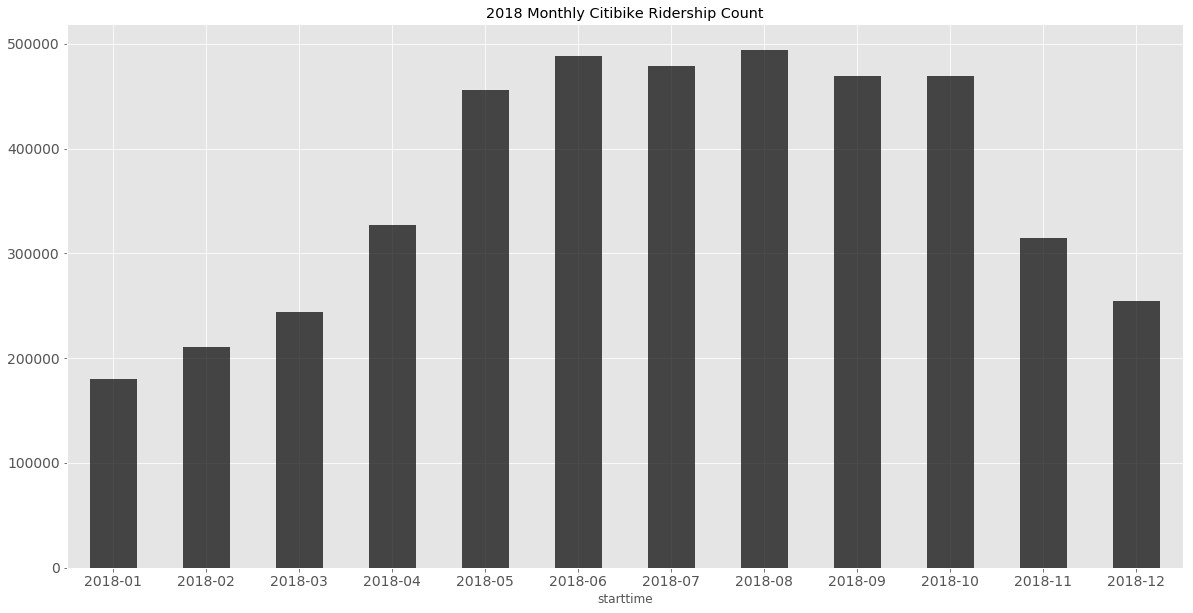

In [15]:
# Draw a basic plot for the monthly ridership data
monthly_answer.plot(
    figsize=(20,10), 
    kind='bar',
    title='2018 Monthly Citibike Ridership Count',
    fontsize=14,
    color='k',
    alpha=0.7,
    rot=0)

# Finally learned how to do it, you have to assign it to an object first.
# Reference: https://stackoverflow.com/a/21487560

# Then use set_xlable ...
# ax.set_xlabel('')

# Very complicated, 
# Reference: https://stackoverflow.com/a/25973637
# ax.get_yaxis().set_major_formatter(
#    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

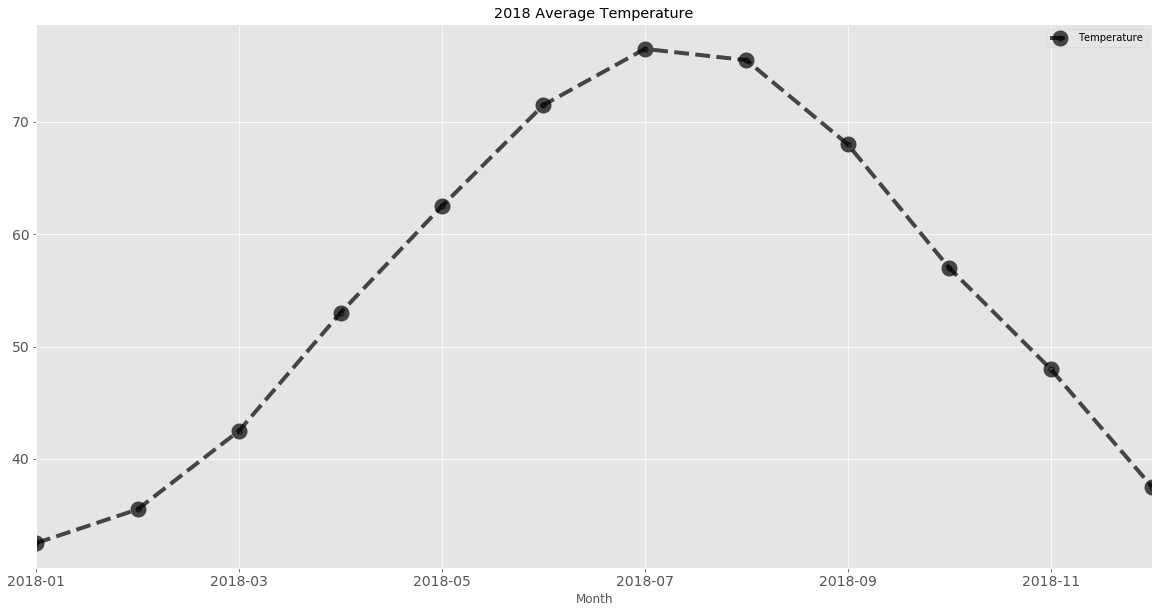

In [16]:
# Create a monthly temperature dictionary, data otained from google.
# probably need to find a way to get daily temperature in order to do more 
# in depth analysis and build a regression model.
temperature_dict = {
    'Month':['2018-01', 
             '2018-02',
             '2018-03',
             '2018-04',
             '2018-05',
             '2018-06',
             '2018-07',
             '2018-08',
             '2018-09',
             '2018-10',
             '2018-11',
             '2018-12'],
    'Temperature':[32.5, 35.5, 42.5, 53, 62.5, 71.5, 76.5, 75.5, 68, 57, 48, 37.5]
}

# Create a dataframe using the dictionary data
temperature_df = pd.DataFrame.from_dict(temperature_dict)

# Rename the columns properly
temperature_df = temperature_df.rename(index=str, columns={"Month": "Month", "Temperature": "Temperature"})

# Learned how to add x & y axis label
temperature_df.plot(
    x='Month',
    y='Temperature',
    figsize=(20,10), 
    kind='line',
    title='2018 Average Temperature',
    fontsize=14,
    linewidth=4.0, 
    markeredgewidth=10.0,
    linestyle='--', 
    marker='o',
    color='k',
    alpha=0.7,
    rot=0
)

In [17]:
# From this we can tell there are a strong relationship between the temperature 
# to the number of riders per day in the citibike. During winter month when it is
# really cold, you don't see nearly as much. But when it is warmer (in the summer)
# then you start to see a huge increase in the number of rides.

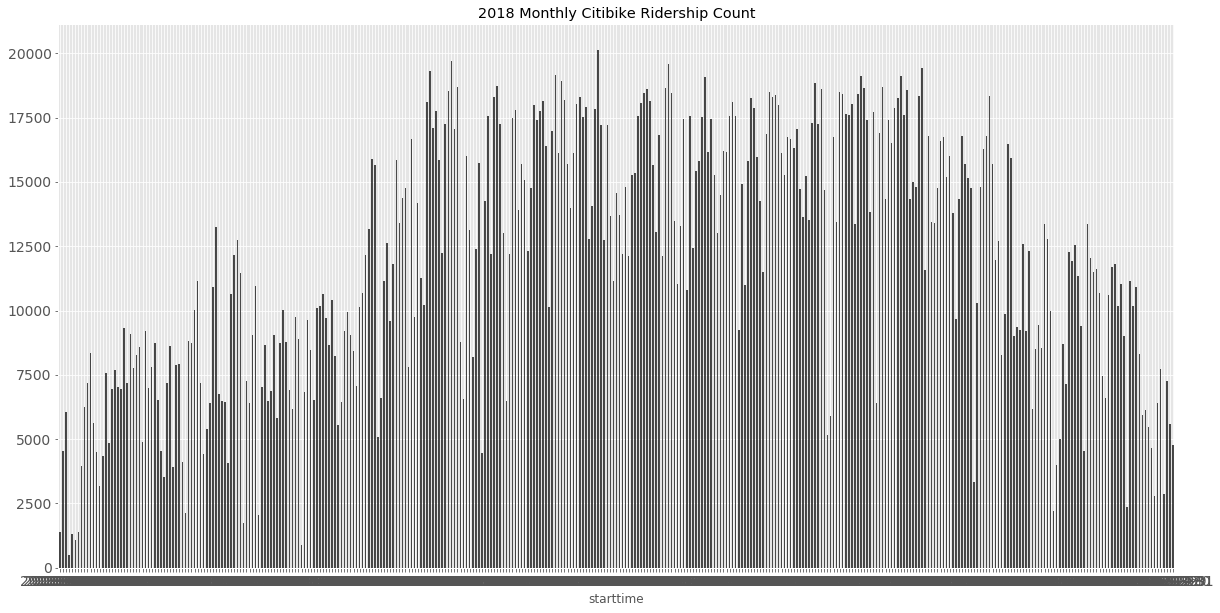

In [18]:
daily_answer.plot(
    figsize=(20,10),
    kind='bar',
    title='2018 Monthly Citibike Ridership Count',
    fontsize=14,
    legend=False,
    color='k',
    alpha=0.7,
    rot=0
)

In [19]:
# Through manual checks on weather history, the dip in the individual months are 
# contributed by rain fall, when it is rainning that day, there are siginficantly
# less people riding a citibike. Because their clothings (pants) will get wet.
# And it is also unsafe to ride in the rain too, better to use mass transit.

# Question 02: What is the most / least popular station?

In [20]:
# Most busy start station
# https://stackoverflow.com/q/29836477
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
key = 'start_station_name'
start_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
start_station_df.sort_values(by = 'count', ascending = False, inplace = True)

# The most popular start stations award goes to...
print('The most popular start station: ' + str(start_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(start_station_df.iloc[0][1]))

# Most busy end station
key = 'end_station_name'
end_station_df = citibike.groupby(key)[key].count().reset_index(name = 'count')
end_station_df.sort_values(by = 'count', ascending = False, inplace = True)

print('The most popular end station:   ' + str(end_station_df.iloc[0][0]), end = '')
print(' ({:,} times)'.format(end_station_df.iloc[0][1]))

# Some information about this station
print('\nFrom Wiki: Pershing Square is a public square in Manhattan, New York City. ')
print('Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.')
print('The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. ')
print('It is also known as the Pershing Square Viaduct.')

Image(url="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Park_Avenue_Viaduct_Pershing_Square_from_west.jpg/1920px-Park_Avenue_Viaduct_Pershing_Square_from_west.jpg",
      width=400, 
      height=400)


# Top 10 one way direction...
# Chart Annual rider vs. Weekly rider vs. Single rider

# School station analysis (Where do they go?)
# Male and Female trips
# Age Group

# Longest trip (Distance formula)
# Shortest trip (Distance formula)
# Holiday trip (Federal Holiday)

The most popular start station: Pershing Square North (37,568 times)
The most popular end station:   Pershing Square North (37,757 times)

From Wiki: Pershing Square is a public square in Manhattan, New York City. 
Located where Park Avenue and 42nd Street intersect in front of Grand Central Terminal.
The main roadway of Park Avenue crosses over 42nd Street on the Park Avenue Viaduct. 
It is also known as the Pershing Square Viaduct.


In [21]:
# https://stackoverflow.com/q/54009788
# This analysis exclude the trip where they start and end at the same station
# Because it is actually central park, I am guessing for tourist?

# Do not want the trip start and end at the same place
citibike_trip = citibike[citibike['start_station_name'] != citibike['end_station_name']]

# Create a subset dataframe with only start & end station name
citibike_trip = citibike_trip.filter(['start_station_name', 'end_station_name'])

# Create the trip string
citibike_trip['trip'] = citibike_trip['start_station_name'] + ' to ' + citibike_trip['end_station_name']

# Group by trip and add count column
trip_df = citibike_trip.groupby('trip')['trip'].count().reset_index(name = 'count')
trip_df.sort_values(by = 'count', ascending = False, inplace = True)

In [22]:
# Print out the result
print('The most popular ride is : ' + trip_df.iloc[0][0], end = '')
print(' ({} times)'.format(trip_df.iloc[0][1]))

# How to insert an image: https://stackoverflow.com/a/32370538
Image(url="https://i.ibb.co/J72SggW/map1.png",
      width=600, 
      height=600)

The most popular ride is : E 7 St & Avenue A to Cooper Square & Astor Pl (1890 times)


In [23]:
print('The least popular ride is: ' + trip_df.iloc[-1][0], end = '')
print(' ({} times)'.format(trip_df.iloc[-1][1]))

Image(url="https://i.ibb.co/vmJVfx8/map2.png",
      width=600, 
      height=600)

The least popular ride is: old - E 13 St & Avenue A to Watts St & Greenwich St (1 times)


In [24]:
# Lookup the geo-coordinate for google map lookup
# citibike[citibike.start_station_name == 'Watts St & Greenwich St']

# Top 10 poupar trips in 2018

In [25]:
# Take a look at the top 10 popular trips
trip_df.head(10)

,trip,count
113189,E 7 St & Avenue A to Cooper Square & Astor Pl,1890
60348,Central Park S & 6 Ave to 5 Ave & E 88 St,1551
189570,S 4 St & Wythe Ave to N 6 St & Bedford Ave,1409
171666,N 6 St & Bedford Ave to S 4 St & Wythe Ave,1280
215878,W 21 St & 6 Ave to 9 Ave & W 22 St,1260
179248,Pershing Square North to W 33 St & 7 Ave,1175
178831,Pershing Square North to Broadway & W 32 St,1124
178949,Pershing Square North to E 24 St & Park Ave S,1079
6495,12 Ave & W 40 St to West St & Chambers St,1068
76014,DeKalb Ave & Vanderbilt Ave to DeKalb Ave & Hu...,1065


## There are many 1 off trips (not meaningful to say least popular)

In [26]:
count = trip_df[trip_df['count'] == 1].shape[0]

# These are station to station ride that only happened once
print('There are {0:,} count of one-off trips.'.format(count))

There are 58,080 count of one-off trips.


# What are the type of membership (Annual members or paid per ride?)

In [27]:
membership_df = citibike.groupby('usertype')['usertype'].count()
membership_df = membership_df.reset_index(name = 'count')
membership_df = membership_df.set_index(['usertype'])

# Set the index so it will print properly
membership_df

,count
usertype,
Customer,483312
Subscriber,3903118


In [28]:
# This is george's another way of getting the count and making it 
# back to a DataFrame, after reading the book a bunch.
membership = citibike.groupby('usertype')['usertype'].count()

# In order to use pd.plot, but maybe you use can it as is?
membership = pd.DataFrame(membership)
membership.rename(columns={'usertype': 'count'})

,count
usertype,
Customer,483312
Subscriber,3903118


In [29]:
# This is a break through!!!
membership = citibike.groupby('usertype')['usertype'].count()

count = list(membership)
label = list(membership.index)
print(label)
print(count)

['Customer', 'Subscriber']
[483312, 3903118]


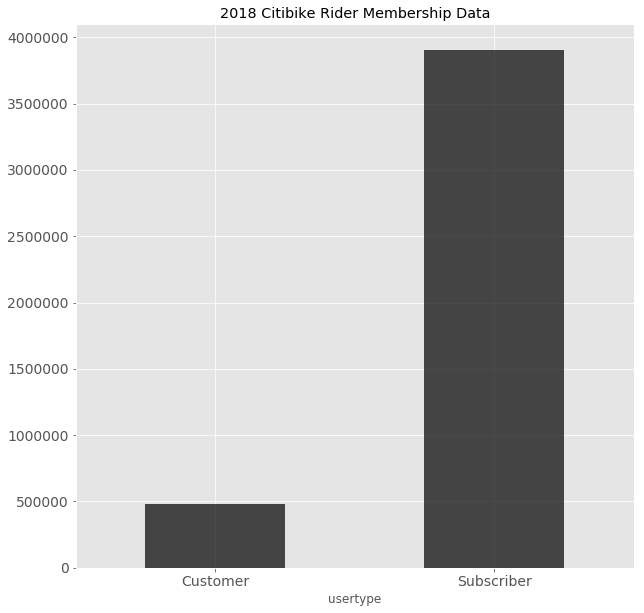

In [30]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
membership_df.plot(
    figsize=(10,10),
    title='2018 Citibike Rider Membership Data', 
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7,
    )

In [31]:
gender_df = citibike.groupby('gender')['gender'].count()
gender_df = gender_df.reset_index(name = 'count')
gender_df = gender_df.set_index(['gender'])

# Set the index so it will print properly
gender_df.rename(index={0: 'Unknown', 
                        1: 'Male',
                        2: 'Female'}, inplace=True)

In [32]:
foo = citibike.groupby('gender')['gender'].count()
foo

gender
0     371634
1    2993095
2    1021701
Name: gender, dtype: int64

In [33]:
foo.index=['Unknown', 'Male', 'Female']
foo

Unknown     371634
Male       2993095
Female     1021701
Name: gender, dtype: int64

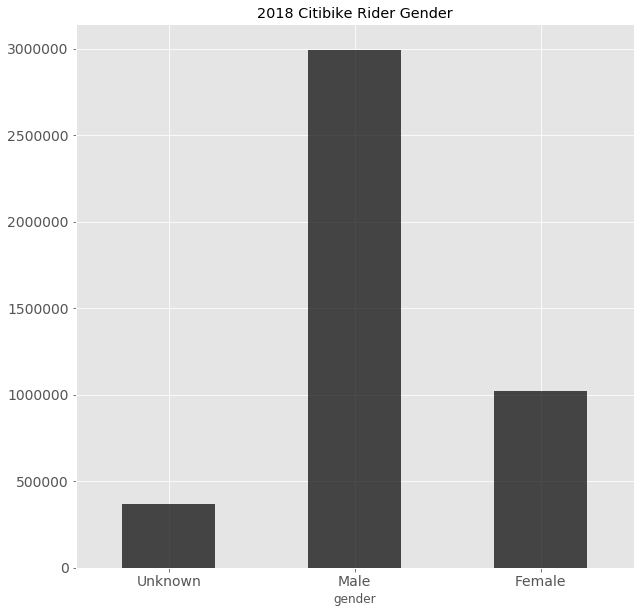

In [34]:
# Reference: https://markhneedham.com/blog/2018/09/18/matplotlib-remove-axis-legend/
gender_df.plot(
    figsize=(10,10),
    title='2018 Citibike Rider Gender',
    fontsize=14,
    kind='bar',
    rot=0,
    legend=None,
    color='k',
    alpha=0.7
)

In [35]:
# Age Group
# https://stackoverflow.com/a/34683105
age_df = citibike[['birth_year']].copy()

# Replace the column names
age_df.columns = age_df.columns.str.strip().str.lower().str.replace(' ', '_')

# Failed attempt...
# age_df['age'] = age_df.apply(lambda row: row['birth_year'])

def get_age(year_of_birth):
    result = 2019 - int(year_of_birth)
    if result >= 0 and result <=80 and result != 50:
        return result
    else:
        return -1

# Calculate a new column by using vectorize method
age_df['age'] = np.vectorize(get_age)(age_df['birth_year'])

age_df = age_df[age_df['age'] != -1]

age_plot_df = age_df.groupby('age')['age'].count()
age_plot_df = age_plot_df.reset_index(name = 'count')
age_plot_df = age_plot_df.set_index(['age'])

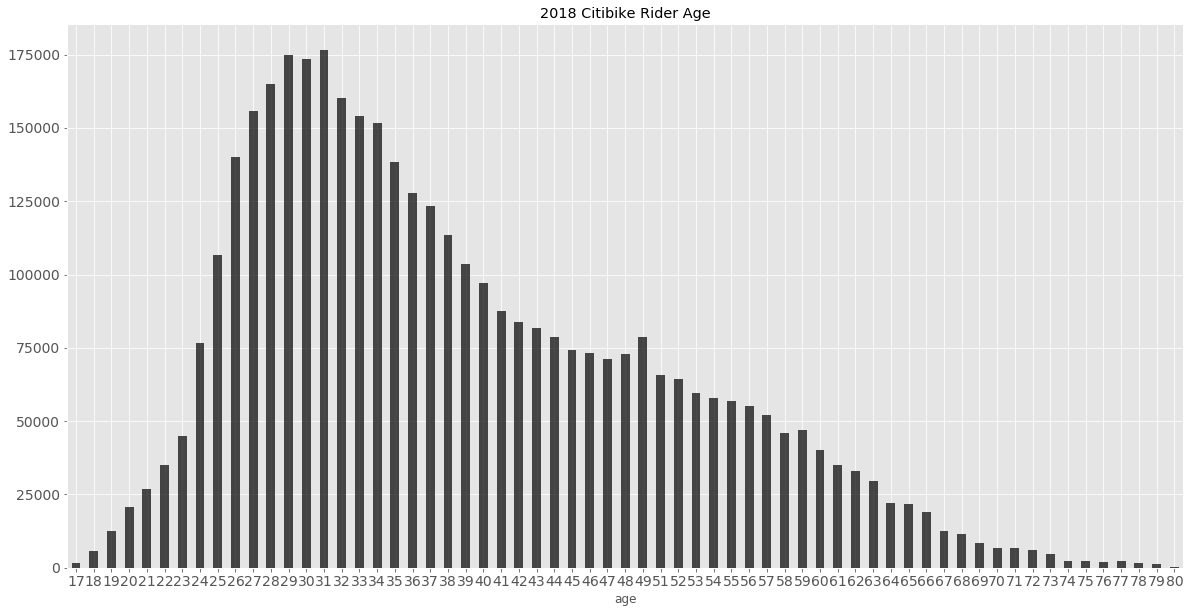

In [36]:
age_plot_df.plot(
    figsize = (20,10), 
    title = '2018 Citibike Rider Age', 
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None,
    color='k',
    alpha=0.7
)

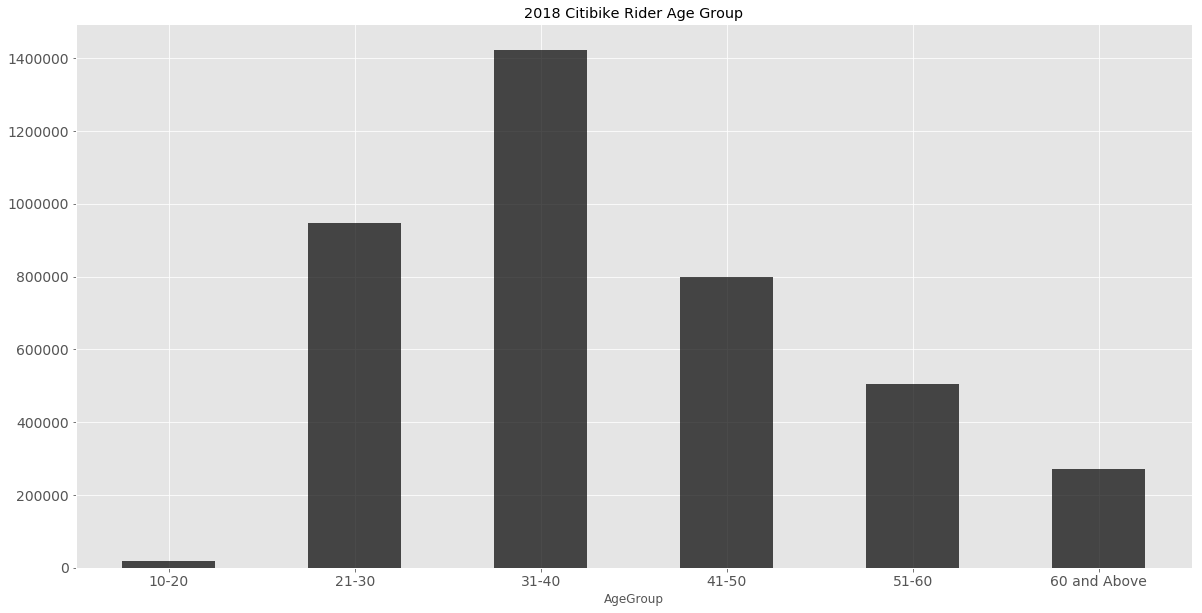

In [37]:
# bins = [0, 24, 59, 999]
# labels = ['Student <=24','Adult','Senior Adult']

bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['10-20', '21-30', '31-40', '41-50', '51-60', '60 and Above']

age_df['AgeGroup'] = pd.cut(age_df['age'], bins=bins, labels=labels, right=False)

agegroup_plot_df = age_df.groupby('AgeGroup')['AgeGroup'].count()
agegroup_plot_df = agegroup_plot_df.reset_index(name = 'count')
agegroup_plot_df = agegroup_plot_df.set_index(['AgeGroup'])

agegroup_plot_df.plot(
    figsize = (20,10), 
    title = '2018 Citibike Rider Age Group', 
    fontsize = 14,
    kind = 'bar',
    rot = 0,
    legend = None,
    color='k',
    alpha=0.7
)

In [38]:
# https://stackoverflow.com/a/43211266
from math import sin, cos, sqrt, atan2, radians


def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in miles 
    R = 3958.8

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def get_duration(datetime1, datetime2):
    # https://stackoverflow.com/a/14920923
    duration = datetime2 - datetime1
    return duration.total_seconds()
    
def get_speed(distance, duration):
    hour = 60.0 * 60.0 * 60.0 / (seconds)
    
    # return distance per hour
    return (distance/hour)

ans = get_distance(40.729538, -73.984267, 40.736197, -74.008592)
ans = get_distance(40.730260, -73.953940, 40.729060, -73.957790)

print("Result:", ans)

Result: 0.21796866823983926


In [39]:
import numpy as np

df = citibike.sample(frac = 0.1, replace = True, random_state = 1)

# Vectorize: https://stackoverflow.com/q/19914937
# start station latitude, start station longitude
df['distance'] = np.vectorize(get_distance)(df['start_station_latitude'],
                                     df['start_station_longitude'],
                                     df['end_station_latitude'],
                                     df['end_station_longitude'])



# df['duration'] = np.vectorize(get_duration)(df['starttime'], df['stoptime'])
# df['C'] = (df['B'] - df['A'])/ np.timedelta64(1, 's')
df['duration'] = (df['stoptime'] - df['starttime']) / np.timedelta64(1, 's')

df['speed'] = (df['distance'] / ((60.0 * 60.0) / df['duration']))

# citibike_trip = citibike[citibike['start station name'] != citibike['end station name']]
commute_trip = df[df['start_station_name'] != df['end_station_name']]

# Limit the ride that is slower than walking and within reason (race bike...)
commute_trip = commute_trip[(commute_trip['speed'] >= 3.5)
                            & (commute_trip['speed'] <= 25)]

# commute_trip = commute_trip[commute_trip['birth year'] >= 1989]

'''
Speeds above 16 mph are considered very vigorous while riding a bicycle. 
A light pace would be 10 to 11.9 mph while a moderate pace is categorized as 12 to 13.9 mph. 
If you are a beginner, start at a light or moderate pace and ride at speeds between 10 and 14 mph.
'''

speed_bins = [0, 9, 12, 15, 99]
speed_labels = ['Leisurely (< 9 MPH)', 'Fast MPH (9 - 11.9 MPH)', 'Moderate (12 - 14.9 MPH)', 'Vigorous (15 MPH+)']

commute_trip['SpeedGroup'] = pd.cut(commute_trip['speed'], bins=speed_bins, labels=speed_labels, right=False)

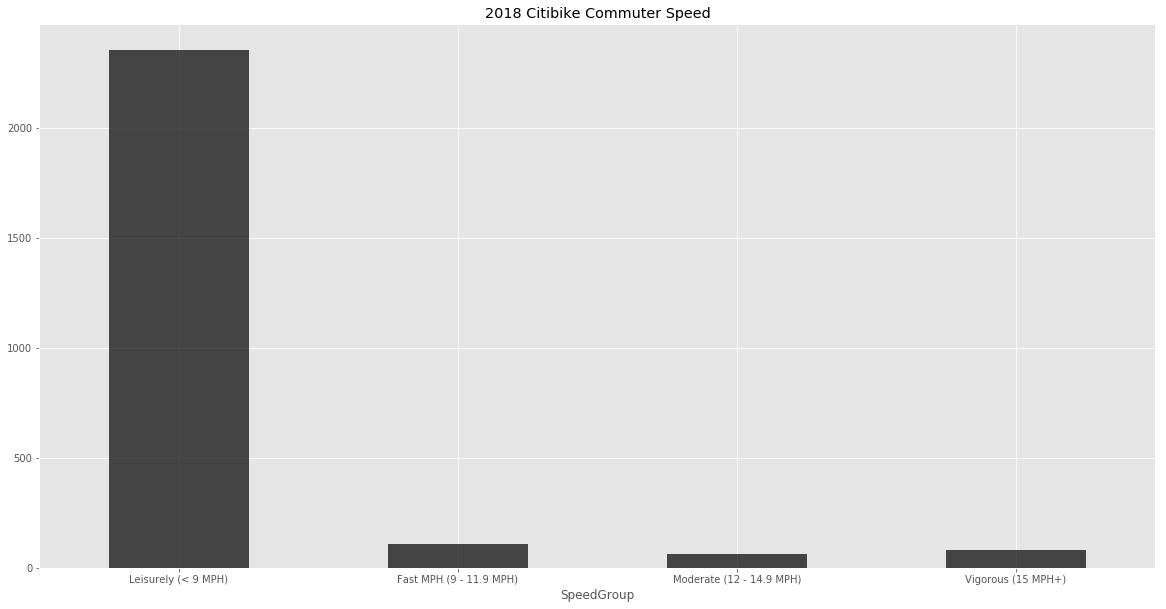

In [40]:
commute_trip_plot = commute_trip.groupby('SpeedGroup')['SpeedGroup'].count()
commute_trip_plot = commute_trip_plot.reset_index(name = 'count')
commute_trip_plot = commute_trip_plot.set_index(['SpeedGroup'])

commute_trip_plot.plot(
    figsize = (20,10), 
    title = '2018 Citibike Commuter Speed', 
    kind = 'bar',
    rot = 0,
    legend = None,
    color='k',
    alpha=0.7
)

# Question 4: Advanced commuting analysis

In [41]:
# Example of connected trip.
# Same gender and year of birth started in the same station within 5 minutes.

# Example of regular commuter rides
# Start and end station by the same user?
# Morning starting on the train station and ending on the same station

# Year of Birth & Gender (Start time and station)
# Working age adult: 7am-9am trips, where they do they go to work at?

In [42]:
# Helper function to determine if datetime is between a time
def check_commute_hour(my_hour):
    if (my_hour >= 6 and my_hour <= 10):
        return 'Morning'
    elif (my_hour >= 16 and my_hour <= 21):
        return 'Evening'
    else:
        return 'Other'

# Morning Ride (6am-10am)
commute_df = citibike[['tripduration', 'starttime', 
                       'start_station_name', 'end_station_name', 
                       'usertype', 'birth_year', 'gender']].copy()

commute_df = commute_df.loc[commute_df['usertype'] == 'Subscriber']

In [43]:
# Set a True or False Flag between 6am-10am (24 hour time format)
# Link: https://stackoverflow.com/a/45564365
# Super helpful trick to get the dt.hour (hour portion)
commute_df['commute_type'] = np.vectorize(check_commute_hour)(commute_df['starttime'].dt.hour)
commute_df['date'] = commute_df['starttime'].dt.date

commute_df = commute_df.loc[commute_df['commute_type'] != 'Other']

# Exclude daily ride, unknown gender and unknow age
# How to filter by values: https://stackoverflow.com/a/17071908
# df.loc[df['column_name'] == some_value]
morning_commute_df = commute_df.loc[commute_df['commute_type'] == 'Morning']
evening_commute_df = commute_df.loc[commute_df['commute_type'] == 'Evening']

In [44]:
# Create a Ukey to join easier
morning_commute_df['Ukey'] = (morning_commute_df['usertype'] + '-' + 
                     morning_commute_df['birth_year'].map(str) + '-' + 
                     morning_commute_df['gender'].map(str) + '-' + 
                     morning_commute_df['date'].map(str) + '-' +
                     morning_commute_df['start_station_name'] + '-' +
                     morning_commute_df['end_station_name'])

evening_commute_df['Ukey'] = (evening_commute_df['usertype'] + '-' + 
                     evening_commute_df['birth_year'].map(str) + '-' + 
                     evening_commute_df['gender'].map(str) + '-' + 
                     evening_commute_df['date'].map(str) + '-' +
                     evening_commute_df['end_station_name'] + '-' +
                     evening_commute_df['start_station_name'])

# Index by Ukey
morning_commute_df = morning_commute_df.set_index('Ukey')
evening_commute_df = evening_commute_df.set_index('Ukey')

/Users/Study/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/Study/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# How to get dataframe column and types
# morning_df['starttime'].dtype << Just 1 column
# https://stackoverflow.com/a/43852726
print(type(morning_commute_df))
print(morning_commute_df.dtypes)
morning_commute_df.head(5)

<class 'pandas.core.frame.DataFrame'>
tripduration                   int64
starttime             datetime64[ns]
start_station_name            object
end_station_name              object
usertype                      object
birth_year                     int64
gender                         int64
commute_type                  object
date                          object
dtype: object


,tripduration,starttime,start_station_name,end_station_name,usertype,birth_year,gender,commute_type,date
Ukey,,,,,,,,,
Subscriber-1989-1-2018-01-18-Greenpoint Ave & Manhattan Ave-Milton St & Franklin St,126,2018-01-18 09:31:57.538,Greenpoint Ave & Manhattan Ave,Milton St & Franklin St,Subscriber,1989,1,Morning,2018-01-18
Subscriber-1985-1-2018-01-16-E 6 St & Avenue B-Lafayette St & E 8 St,340,2018-01-16 07:24:13.551,E 6 St & Avenue B,Lafayette St & E 8 St,Subscriber,1985,1,Morning,2018-01-16
Subscriber-1962-1-2018-01-13-W 59 St & 10 Ave-W 31 St & 7 Ave,790,2018-01-13 08:49:22.410,W 59 St & 10 Ave,W 31 St & 7 Ave,Subscriber,1962,1,Morning,2018-01-13
Subscriber-1991-1-2018-01-31-E 39 St & 3 Ave-Broadway & W 41 St,360,2018-01-31 08:50:10.374,E 39 St & 3 Ave,Broadway & W 41 St,Subscriber,1991,1,Morning,2018-01-31
Subscriber-1989-2-2018-01-25-Grand Ave & Bergen St-Park Pl & Vanderbilt Ave,321,2018-01-25 08:16:50.244,Grand Ave & Bergen St,Park Pl & Vanderbilt Ave,Subscriber,1989,2,Morning,2018-01-25


In [46]:
# Join the two dataframe to get continued trip (need them to the same date)
round_trip_df = morning_commute_df.join(evening_commute_df, how='inner', on='Ukey', lsuffix='', rsuffix='_right')

In [47]:
# Round trip dataframe! :)
round_trip_df = round_trip_df.sort_values(by ='date')

In [48]:
# Next question is how to show it on google map?
round_trip_view_df = round_trip_df.drop(
    ['usertype_right', 'birth_year_right', 'gender_right','date_right'] 
    , axis=1)

round_trip_view_df = round_trip_view_df.loc[round_trip_view_df['tripduration'] >= 600]
round_trip_view_df = round_trip_view_df.sort_values('date')

In [49]:
# DataFrame.drop_duplicates
round_trip_df = round_trip_df.drop_duplicates()
round_trip_df.shape

(17644, 18)

In [50]:
round_trip_df.sample(5)

,tripduration,starttime,start_station_name,end_station_name,usertype,birth_year,gender,commute_type,date,tripduration_right,starttime_right,start_station_name_right,end_station_name_right,usertype_right,birth_year_right,gender_right,commute_type_right,date_right
Ukey,,,,,,,,,,,,,,,,,,
Subscriber-1979-1-2018-11-07-Prospect Pl & 6 Ave-Schermerhorn St & Bond St,528,2018-11-07 08:49:36.365,Prospect Pl & 6 Ave,Schermerhorn St & Bond St,Subscriber,1979,1,Morning,2018-11-07,510,2018-11-07 18:53:30.796,Schermerhorn St & Bond St,Prospect Pl & 6 Ave,Subscriber,1979,1,Evening,2018-11-07
Subscriber-1986-1-2018-08-02-Kent Ave & N 7 St-Bedford Ave & Nassau Ave,267,2018-08-02 08:06:02.063,Kent Ave & N 7 St,Bedford Ave & Nassau Ave,Subscriber,1986,1,Morning,2018-08-02,354,2018-08-02 16:56:46.946,Bedford Ave & Nassau Ave,Kent Ave & N 7 St,Subscriber,1986,1,Evening,2018-08-02
Subscriber-1969-0-2018-08-14-Broadway & W 56 St-E 47 St & Park Ave,558,2018-08-14 07:54:07.803,Broadway & W 56 St,E 47 St & Park Ave,Subscriber,1969,0,Morning,2018-08-14,481,2018-08-14 19:07:26.918,E 47 St & Park Ave,Broadway & W 56 St,Subscriber,1969,0,Evening,2018-08-14
Subscriber-1982-1-2018-10-19-W 17 St & 9 Ave-Johnson St & Gold St,1671,2018-10-19 09:07:49.232,W 17 St & 9 Ave,Johnson St & Gold St,Subscriber,1982,1,Morning,2018-10-19,1509,2018-10-19 18:37:41.642,Johnson St & Gold St,W 17 St & 9 Ave,Subscriber,1982,1,Evening,2018-10-19
Subscriber-1984-1-2018-04-10-W 34 St & 11 Ave-12 Ave & W 40 St,208,2018-04-10 08:54:32.625,W 34 St & 11 Ave,12 Ave & W 40 St,Subscriber,1984,1,Morning,2018-04-10,233,2018-04-10 20:10:35.926,12 Ave & W 40 St,W 34 St & 11 Ave,Subscriber,1984,1,Evening,2018-04-10
